# 2.a Data Preprocessing and Feature Engineering (LSTM)

### Import necessary Packages

In [1]:
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import boto3 
import io  
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
session = boto3.Session()

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sagemaker
from sagemaker import get_execution_role

### Getting Data from Yahoo Finance¶

In [4]:
btc = f'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1656633600&interval=1d&events=history&includeAdjustedClose=true'

### Load the Data

In [5]:
data= pd.read_csv(btc)

In [6]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
data.shape

(2845, 7)

### Making new dataframe with requried features

In [8]:
data = data[['Date','Open','Close']]

### Setting date as the index

In [9]:
data.set_index('Date',drop=True,inplace=True) 

In [10]:
data.head()

,Open,Close
Date,,
2014-09-17,465.864014,457.334015
2014-09-18,456.859985,424.440002
2014-09-19,424.102997,394.795990
2014-09-20,394.673004,408.903992
2014-09-21,408.084991,398.821014


In the table above, we see that Date is set as the index and two features have been seleced which are the Opening and Closing price of Bitcoin on that day

### Plotting the Open and Close trend

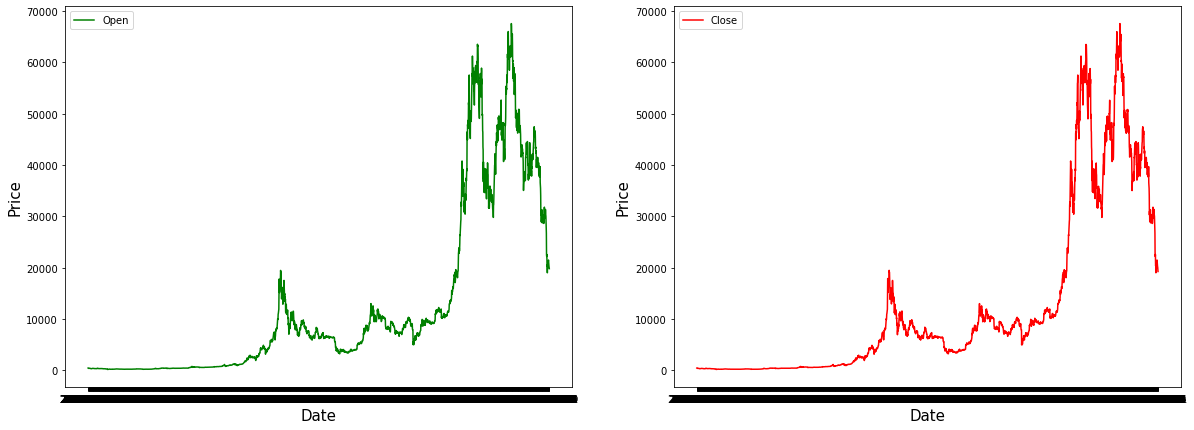

In [11]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(data['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(data['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2845 entries, 2014-09-17 to 2022-07-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2845 non-null   float64
 1   Close   2845 non-null   float64
dtypes: float64(2)
memory usage: 66.7+ KB


### Taking a look at the skewed data

In [13]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

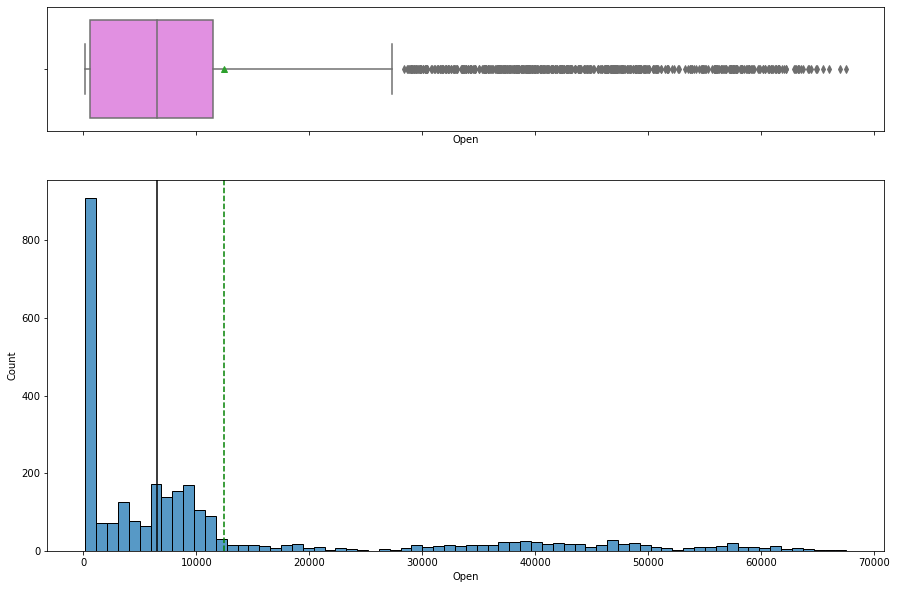

In [14]:
histogram_boxplot(data,"Open",bins=70)

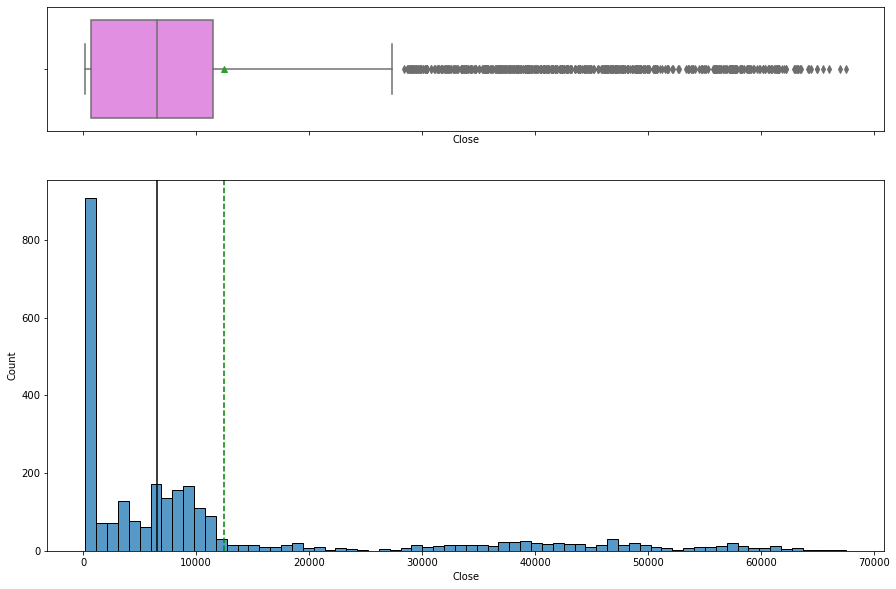

In [15]:
histogram_boxplot(data,"Close",bins=70)

We see that the data is spread across a wide range from 0 dollars to 70000 dolars. We will fix the issue by scaling and normalizing the data to be between 0 and 1

### Scaling the data and splitting the data for Open and close prices

#### Close Prices

In [30]:
close_prices = data['Close']
values = close_prices.values
training_data_len_close = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_close = scaler.fit_transform(values.reshape(-1, 1))
train_data_close = scaled_data_close[0: training_data_len_close, :]

x_train_close = []
y_train_close = []

for i in range(60, len(train_data_close)):
    x_train_close.append(train_data_close[i-60:i, 0])
    y_train_close.append(train_data_close[i, 0])
x_train_close, y_train_close = np.array(x_train_close), np.array(y_train_close)
x_train_close = np.reshape(x_train_close, (x_train_close.shape[0], x_train_close.shape[1], 1))

In [31]:
test_data_close = scaled_data_close[training_data_len_close-60: , : ]
x_test_close = []
y_test_close = values[training_data_len_close:]

for i in range(60, len(test_data_close)):
    x_test_close.append(test_data_close[i-60:i, 0])

x_test_close = np.array(x_test_close)
x_test_close = np.reshape(x_test_close, (x_test_close.shape[0], x_test_close.shape[1], 1))

#### Open Prices

In [32]:
open_prices = data['Open']
values_open = open_prices.values
training_data_len_open = math.ceil(len(values_open)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_open = scaler.fit_transform(values_open.reshape(-1, 1))
train_data_open = scaled_data_open[0: training_data_len_open, :]

x_train_open = []
y_train_open = []

for i in range(60, len(train_data_open)):
    x_train_open.append(train_data_open[i-60:i, 0])
    y_train_open.append(train_data_open[i, 0])
x_train_open, y_train_open = np.array(x_train_open), np.array(y_train_open)
x_train_open = np.reshape(x_train_open, (x_train_open.shape[0], x_train_open.shape[1], 1))

In [33]:
test_data_open= scaled_data_open[training_data_len_open-60: , : ]
x_test_open = []
y_test_open = values_open[training_data_len_open:]

for i in range(60, len(test_data_open)):
    x_test_open.append(test_data_open[i-60:i, 0])

x_test_open = np.array(x_test_open)
x_test_open = np.reshape(x_test_open, (x_test_open.shape[0], x_test_open.shape[1], 1))

### Looking at the shape of the Train and Test data

#### Close

In [15]:
print(x_train_close.shape)
print(x_test_close.shape)

(2216, 60, 1)
(569, 60, 1)


In [16]:
print(y_train_close.shape)
print(y_test_close.shape)

(2216,)
(569,)


#### Open

In [17]:
print(x_train_open.shape)
print(x_test_open.shape)

(2216, 60, 1)
(569, 60, 1)


In [18]:
print(y_train_open.shape)
print(y_test_open.shape)

(2216,)
(569,)


### Export Data for Model Training

In [19]:
np.save("x_train_close.npy", x_train_close)
np.save("x_test_close.npy", x_test_close)
np.save("y_train_close.npy", y_train_close)
np.save("y_test_close.npy", y_test_close)
np.save("x_train_open.npy", x_train_open)
np.save("x_test_open.npy", x_test_open)
np.save("y_train_open.npy", y_train_open)
np.save("y_test_open.npy", y_test_open)

In [20]:
s3 = session.resource('s3') 
local_path = 'x_train_close.npy' 
s3_filename =  'x_train_close.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [21]:
s3 = session.resource('s3') 
local_path = 'x_test_close.npy' 
s3_filename =  'x_test_close.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [22]:
s3 = session.resource('s3') 
local_path = 'y_train_close.npy' 
s3_filename =  'y_train_close.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [23]:
s3 = session.resource('s3') 
local_path = 'y_test_close.npy' 
s3_filename =  'y_test_close.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [24]:
s3 = session.resource('s3') 
local_path = 'x_train_open.npy' 
s3_filename =  'x_train_open.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [25]:
s3 = session.resource('s3') 
local_path = 'x_test_open.npy' 
s3_filename =  'x_test_open.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [26]:
s3 = session.resource('s3') 
local_path = 'y_train_open.npy' 
s3_filename =  'y_train_open.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None


In [27]:
s3 = session.resource('s3') 
local_path = 'y_test_open.npy' 
s3_filename =  'y_test_open.npy' 
result = s3.Bucket('data-aman-use-case').upload_file(local_path,s3_filename)  
print(result)

None
